# **Computer Vision and Internet of Things (GRIP March22)**

## **Author: Phue Pyae Maung**

## **Task2: Detection of Face Mask**

 **Download Dataset**

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo" -O FILE && rm -rf /tmp/cookies.txt

--2022-03-16 14:19:53--  https://docs.google.com/uc?export=download&confirm=t&id=1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo
Resolving docs.google.com (docs.google.com)... 74.125.204.101, 74.125.204.100, 74.125.204.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.204.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5i5krjqq2pqmkbuq54j5pcdd24qgnaeh/1647440325000/13528605597967313965/*/1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo?e=download [following]
--2022-03-16 14:19:53--  https://doc-00-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5i5krjqq2pqmkbuq54j5pcdd24qgnaeh/1647440325000/13528605597967313965/*/1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo?e=download
Resolving doc-00-1c-docs.googleusercontent.com (doc-00-1c-docs.googleusercontent.com)... 142.251.8.132, 2404:6800:4008:c15::84
Connecting to doc-00-1c-docs.googleusercontent.com (doc-00-1c-

In [2]:
!unzip FILE

Archive:  FILE
  inflating: face_detector/deploy.prototxt  
  inflating: face_detector/res10_300x300_ssd_iter_140000.caffemodel  
  inflating: mask_detector.model     
  inflating: dataset/with_mask/with_mask651.jpeg  
  inflating: dataset/with_mask/with_mask641.jpeg  
  inflating: dataset/with_mask/with_mask649.jpeg  
  inflating: dataset/with_mask/with_mask638.jpeg  
  inflating: dataset/with_mask/with_mask645.jpeg  
  inflating: dataset/with_mask/with_mask648.jpeg  
  inflating: dataset/with_mask/with_mask650.jpeg  
  inflating: dataset/with_mask/with_mask659.jpeg  
  inflating: dataset/with_mask/with_mask654.jpeg  
  inflating: dataset/with_mask/with_mask647.jpeg  
  inflating: dataset/with_mask/with_mask653.jpeg  
  inflating: dataset/with_mask/with_mask637.jpeg  
  inflating: dataset/without_mask/augmented_image_25.jpg  
  inflating: dataset/with_mask/with_mask640.jpeg  
  inflating: dataset/with_mask/with_mask644.jpeg  
  inflating: dataset/with_mask/with_mask639.jpeg  
  inflat

**Import Libraries**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
from google.colab.patches import cv2_imshow
from imutils.video import VideoStream
import time
import sys

**Import Model**

In [4]:
#Setting path to configuration file
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])

#setting path to weights
weightsPath = os.path.sep.join(["face_detector",
	"res10_300x300_ssd_iter_140000.caffemodel"])

#Creating the network to detect faces
net = cv2.dnn.readNet(prototxtPath, weightsPath)

**Training**

In [5]:
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
 
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

**Create Model**

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
LR = 1e-4     #learning rate
EPOCHS = 10    #no. of epochs
BS = 32       #batch size

#We will use Adam Optimizer for our model
opt= Adam(lr=LR, decay=LR / EPOCHS)

#To compile the model we use 'binary crossentropy' as loss function and set the metrics to accuracy
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/10
95/95 [==============================] - 143s 1s/step - loss: 0.3758 - accuracy: 0.8757 - val_loss: 0.1546 - val_accuracy: 0.9765
Epoch 2/10
95/95 [==============================] - 136s 1s/step - loss: 0.1526 - accuracy: 0.9598 - val_loss: 0.0846 - val_accuracy: 0.9831
Epoch 3/10
95/95 [==============================] - 137s 1s/step - loss: 0.0966 - accuracy: 0.9776 - val_loss: 0.0626 - val_accuracy: 0.9831
Epoch 4/10
95/95 [==============================] - 135s 1s/step - loss: 0.0781 - accuracy: 0.9796 - val_loss: 0.0517 - val_accuracy: 0.9831
Epoch 5/10
95/95 [==============================] - 135s 1s/step - loss: 0.0681 - accuracy: 0.9812 - val_loss: 0.0486 - val_accuracy: 0.9844
Epoch 6/10
95/95 [==============================] - 137s 1s/step - loss: 0.0571 - accuracy: 0.9842 - val_loss: 0.0431 - val_accuracy: 0.9831
Epoch 7/10
95/95 [==============================] - 136s 1s/step - loss: 0.0508 - accuracy: 0.9852 - val_loss: 0.0397 - val_accuracy: 0.9883
Epoch 8/10
95

In [12]:
preds = model.evaluate(testX, testY)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

24/24 [==============================] - 22s 909ms/step - loss: 0.0349 - accuracy: 0.9896
Loss = 0.0348883792757988
Test Accuracy = 0.9895697236061096


In [13]:
model.save("model", save_format="h5")

**Detection on Image**

In [14]:
model = load_model("model")

In [15]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [16]:
def take_photo(filename='/content/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [17]:
image_file = take_photo()

<IPython.core.display.Javascript object>

400 300


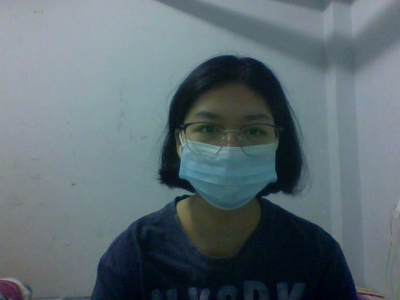

In [18]:
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

In [19]:
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [20]:
net.setInput(blob)
detections = net.forward()

In [21]:
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter. out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

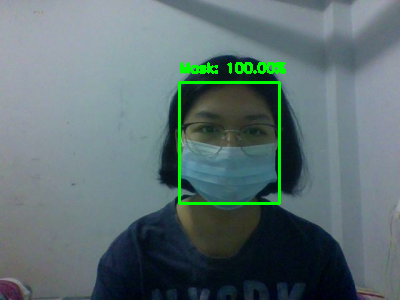

In [22]:
cv2_imshow(image)

In [23]:
!pip install ffmpeg-python

In [24]:
import io
import ffmpeg
from IPython.display import HTML
import PIL
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from base64 import b64decode, b64encode

In [25]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
  # return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [26]:
maskNet = load_model("model")

In [27]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label_html, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array) # numpy array into PIL image object
  iobuf = io.BytesIO()
  
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')

  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

<IPython.core.display.Javascript object>

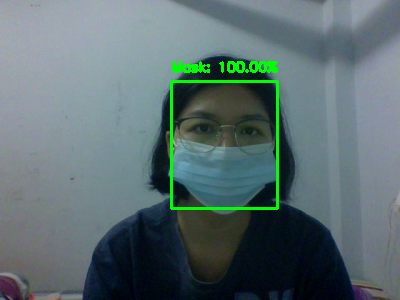

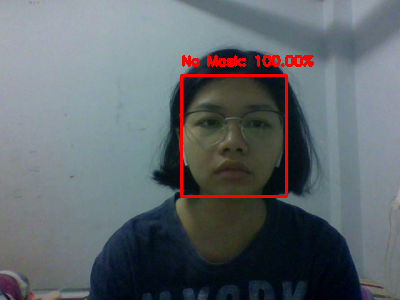

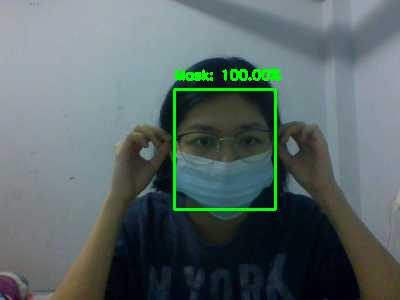

In [29]:
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    

    # convert JS response to OpenCV Image
    image = js_to_image(js_reply["img"])
    v=True
    if v == True:
      frame = imutils.resize(image, width=400)
    (locs, preds) = detect_and_predict_mask(frame, net, maskNet)
    for (box, pred) in zip(locs, preds):


		# unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    cv2_imshow(frame)